# Data Importing

In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFBb3O8_OBk0FQdwm9gktFUTVeJZU6rM_xHPQ_CNhHAkvt00n578zg
Mounted at /content/drive


In [ ]:
# Upload kaggle API key file
data = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from kaggle
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 1.12G/1.15G [00:14<00:00, 70.9MB/s]
100% 1.15G/1.15G [00:14<00:00, 83.6MB/s]


In [ ]:
# Extract zipfile
import zipfile
zip_ref = zipfile.ZipFile('covid19-radiography-database.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
# Modules for train-val split
import os
import numpy as np
import random
import argparse
from shutil import copyfile

In [ ]:
# Train-val split function
def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)

In [ ]:
!rm -rf '/content/files/COVID-19 Radiography Database/Viral Pneumonia'

In [ ]:
# Run the split function
img_train_test_split('/content/files/COVID-19 Radiography Database',0.7)

Copied 919 images to data/train/NORMAL
Copied 422 images to data/validation/NORMAL
Copied 151 images to data/train/COVID-19
Copied 68 images to data/validation/COVID-19


In [ ]:
!pip install -q pyyaml h5py

# Baseline Model

In [ ]:
# Modules for model creation
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
prec = Precision(name='prec')
rec = Recall(name='rec')

In [ ]:
# Create the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',prec,rec])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 78400)            

In [ ]:
# Label generator
TRAINING_DIR = "/content/data/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(300, 300))

VALIDATION_DIR = "/content/data/validation/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=10,
                                                              class_mode='binary',
                                                              target_size=(300, 300))

Found 1070 images belonging to 2 classes.
Found 490 images belonging to 2 classes.


In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
107/107 [==============================] - 24s 222ms/step - loss: 0.3199 - accuracy: 0.9252 - prec: 0.9320 - rec: 0.9848 - val_loss: 0.1443 - val_accuracy: 0.9408 - val_prec: 0.9758 - val_rec: 0.9550
Epoch 2/100
107/107 [==============================] - 23s 218ms/step - loss: 0.0817 - accuracy: 0.9710 - prec: 0.9826 - rec: 0.9837 - val_loss: 0.1046 - val_accuracy: 0.9694 - val_prec: 0.9976 - val_rec: 0.9668
Epoch 3/100
107/107 [==============================] - 23s 217ms/step - loss: 0.0527 - accuracy: 0.9850 - prec: 0.9924 - rec: 0.9902 - val_loss: 0.0476 - val_accuracy: 0.9857 - val_prec: 0.9929 - val_rec: 0.9905
Epoch 4/100
107/107 [==============================] - 23s 218ms/step - loss: 0.0377 - accuracy: 0.9832 - prec: 0.9902 - rec: 0.9902 - val_loss: 0.0670 - val_accuracy: 0.9735 - val_prec: 0.9952 - val_rec: 0.9739
Epoch 5/100
107/107 [==============================] - 23s 218ms/step - loss: 0.0173 - accuracy: 0.9925 - prec: 0.9956 - rec: 0.9956 - val_loss: 0.0565 

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
def plot_ax(axes, metrics, title, epochs):
    val_met = 'val_' + metrics
    axes.plot(history.history[metrics], c='blue', linewidth=1.5)
    axes.plot(history.history[val_met], c='orange', linewidth=1.5)
    axes.set_title(title)
    axes.set_xticks(range(0, epochs, epochs // 10))
    axes.legend([metrics, val_met], loc='best')
    axes.set_ylabel(metrics)
    axes.grid()

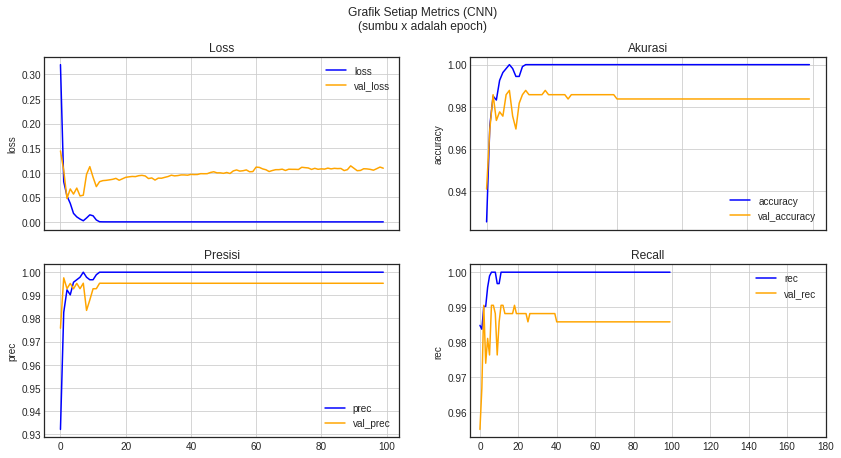

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', 200)
plot_ax(ax[0][1], 'accuracy', 'Akurasi', 200)
plot_ax(ax[1][0], 'prec', 'Presisi', 200)
plot_ax(ax[1][1], 'rec', 'Recall', 200)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Metrics (CNN)\n(sumbu x adalah epoch)')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Kompetisi/SATRIA DATA 2020/SEC/baseline.h5')

#Transfer Learning

In [ ]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, VGG16, VGG19, ResNet50, InceptionResNetV2

##MobileNetV2

In [ ]:
mobile_model=MobileNetV2(input_shape=(300,300,3),include_top=False)

In [ ]:
mobile_model.trainable=False

In [ ]:
mobile_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 301, 301, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
last_output=mobile_model.output
print('last layer output shape: ', mobile_model.output_shape)

last layer output shape:  (None, 10, 10, 1280)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(mobile_model.input, x) 
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f845a20eef0>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',prec,rec])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
107/107 [==============================] - 25s 235ms/step - loss: 4.1861 - accuracy: 0.9645 - prec: 0.9868 - rec: 0.9880 - val_loss: 0.3932 - val_accuracy: 0.9776 - val_prec: 1.0000 - val_rec: 0.9739
Epoch 2/100
107/107 [==============================] - 24s 226ms/step - loss: 0.2973 - accuracy: 0.9888 - prec: 0.9924 - rec: 0.9946 - val_loss: 0.0269 - val_accuracy: 0.9959 - val_prec: 1.0000 - val_rec: 0.9953
Epoch 3/100
107/107 [==============================] - 24s 223ms/step - loss: 0.0614 - accuracy: 0.9972 - prec: 0.9978 - rec: 0.9989 - val_loss: 0.1680 - val_accuracy: 0.9837 - val_prec: 1.0000 - val_rec: 0.9810
Epoch 4/100
107/107 [==============================] - 24s 224ms/step - loss: 0.0653 - accuracy: 0.9972 - prec: 0.9989 - rec: 0.9978 - val_loss: 5.3432e-04 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000
Epoch 5/100
107/107 [==============================] - 24s 225ms/step - loss: 8.0800e-18 - accuracy: 1.0000 - prec: 1.0000 - rec: 1.0000 - val_loss:

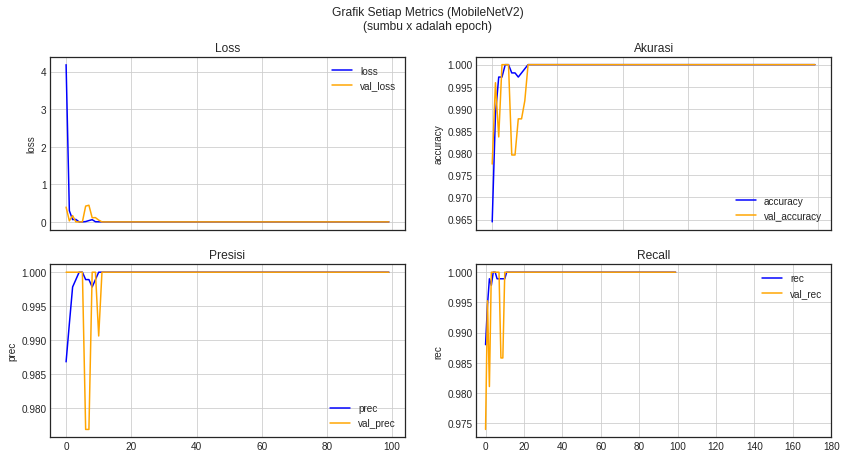

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', 200)
plot_ax(ax[0][1], 'accuracy', 'Akurasi', 200)
plot_ax(ax[1][0], 'prec', 'Presisi', 200)
plot_ax(ax[1][1], 'rec', 'Recall', 200)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Metrics (MobileNetV2)\n(sumbu x adalah epoch)')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Kompetisi/SATRIA DATA 2020/SEC/mobiletrans.h5')

##InceptionV3

In [ ]:
incept_model=InceptionV3(input_shape=(300,300,3),include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
incept_model.trainable=False

In [ ]:
incept_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
last_output=incept_model.output
print('last layer output shape: ', incept_model.output_shape)

last layer output shape:  (None, 8, 8, 2048)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(incept_model.input, x) 
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f8379f7bcc0>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',prec,rec])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
107/107 [==============================] - 25s 238ms/step - loss: 4.4192 - accuracy: 0.9645 - prec: 0.9873 - rec: 0.9843 - val_loss: 0.9006 - val_accuracy: 0.9837 - val_prec: 1.0000 - val_rec: 0.9810
Epoch 2/100
107/107 [==============================] - 25s 230ms/step - loss: 0.5655 - accuracy: 0.9916 - prec: 0.9956 - rec: 0.9946 - val_loss: 0.5745 - val_accuracy: 0.9878 - val_prec: 1.0000 - val_rec: 0.9858
Epoch 3/100
107/107 [==============================] - 25s 229ms/step - loss: 0.7257 - accuracy: 0.9897 - prec: 0.9935 - rec: 0.9946 - val_loss: 1.5046 - val_accuracy: 0.9776 - val_prec: 1.0000 - val_rec: 0.9739
Epoch 4/100
107/107 [==============================] - 25s 230ms/step - loss: 0.4137 - accuracy: 0.9944 - prec: 0.9978 - rec: 0.9956 - val_loss: 0.1476 - val_accuracy: 0.9959 - val_prec: 0.9953 - val_rec: 1.0000
Epoch 5/100
107/107 [==============================] - 24s 229ms/step - loss: 0.5933 - accuracy: 0.9916 - prec: 0.9946 - rec: 0.9956 - val_loss: 0.3080 

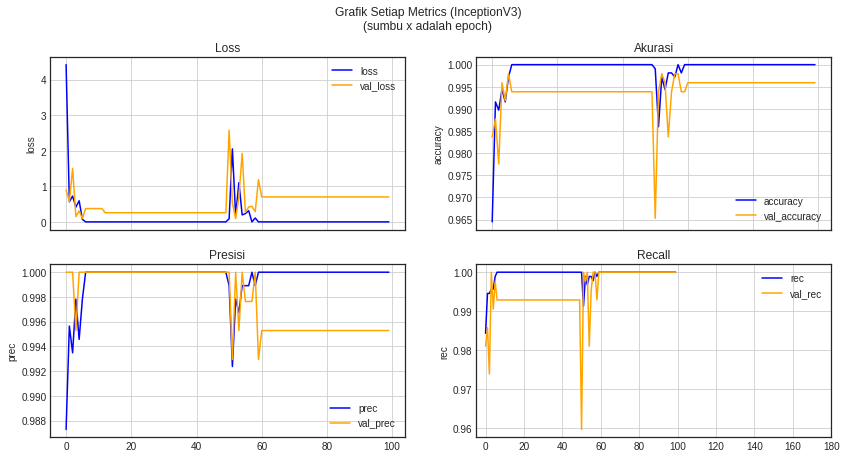

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', 200)
plot_ax(ax[0][1], 'accuracy', 'Akurasi', 200)
plot_ax(ax[1][0], 'prec', 'Presisi', 200)
plot_ax(ax[1][1], 'rec', 'Recall', 200)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Metrics (InceptionV3)\n(sumbu x adalah epoch)')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Kompetisi/SATRIA DATA 2020/SEC/Inceptrans.h5')

##VGG19

In [ ]:
vgg19_model=VGG19(input_shape=(300,300,3),include_top=False)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
vgg19_model.trainable=False

In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [ ]:
last_output=vgg19_model.output
print('last layer output shape: ', vgg19_model.output_shape)

last layer output shape:  (None, 9, 9, 512)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.1)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(vgg19_model.input, x) 
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f83781dc278>>

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy',prec,rec])

In [ ]:
# Fit the model
history = model.fit(train_generator,
                              epochs=100,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/100
107/107 [==============================] - 28s 262ms/step - loss: 0.3610 - accuracy: 0.9533 - prec: 0.9778 - rec: 0.9836 - val_loss: 0.0181 - val_accuracy: 0.9959 - val_prec: 0.9953 - val_rec: 1.0000
Epoch 2/100
107/107 [==============================] - 27s 257ms/step - loss: 0.1542 - accuracy: 0.9776 - prec: 0.9859 - rec: 0.9880 - val_loss: 0.0038 - val_accuracy: 0.9980 - val_prec: 0.9976 - val_rec: 1.0000
Epoch 3/100
107/107 [==============================] - 28s 257ms/step - loss: 0.0433 - accuracy: 0.9944 - prec: 0.9967 - rec: 0.9967 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_prec: 1.0000 - val_rec: 1.0000
Epoch 4/100
107/107 [==============================] - 28s 259ms/step - loss: 0.0113 - accuracy: 0.9953 - prec: 0.9967 - rec: 0.9978 - val_loss: 0.0625 - val_accuracy: 0.9816 - val_prec: 1.0000 - val_rec: 0.9787
Epoch 5/100
107/107 [==============================] - 28s 259ms/step - loss: 0.0744 - accuracy: 0.9850 - prec: 0.9902 - rec: 0.9924 - val_loss: 0.3979 

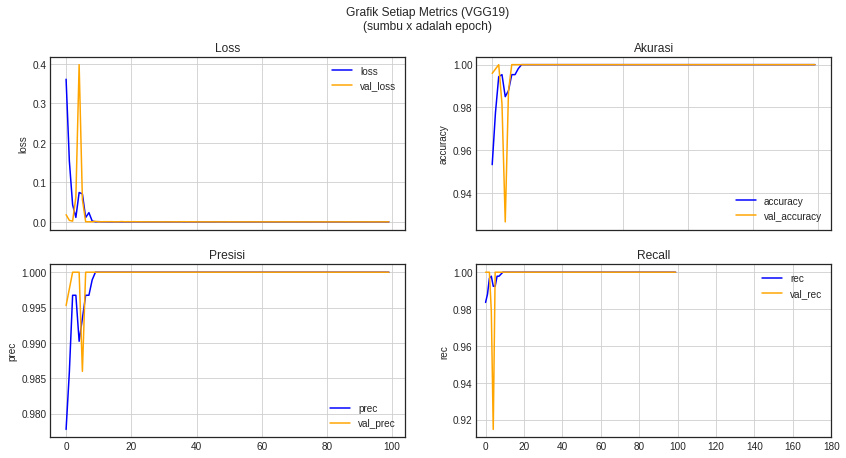

In [ ]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(20, 10))
fig.set_size_inches(14., 7.)
plot_ax(ax[0][0], 'loss', 'Loss', 200)
plot_ax(ax[0][1], 'accuracy', 'Akurasi', 200)
plot_ax(ax[1][0], 'prec', 'Presisi', 200)
plot_ax(ax[1][1], 'rec', 'Recall', 200)
fig = plt.gcf()
plt.suptitle('Grafik Setiap Metrics (VGG19)\n(sumbu x adalah epoch)')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Kompetisi/SATRIA DATA 2020/SEC/VGG19trans.h5')